In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
def _chunk(x, w):
    '''convert into overlapping chunkings. Chunk size = 2w, overlap size = w'''

    # non-overlapping chunks of size = 2w
    x = x.view(x.size(0), x.size(1) // (w * 2), w * 2, x.size(2))

    # use `as_strided` to make the chunks overlap with an overlap size = w
    chunk_size = list(x.size())
    chunk_size[1] = chunk_size[1] * 2 - 1

    chunk_stride = list(x.stride())
    chunk_stride[1] = chunk_stride[1] // 2
    return x.as_strided(size=chunk_size, stride=chunk_stride)

In [3]:
batch_size = 1
seqlen = 16
head_dim = 2
w = 4  # Window size

x = torch.randn(batch_size, seqlen, head_dim).float()
chunked_x = _chunk(x, w=w)

Input tensor x:
torch.Size([1, 16, 2])
tensor([[[-1.1992, -0.4833],
         [ 0.9658,  1.2831],
         [ 1.4472, -0.1551],
         [ 1.6397, -0.1392],
         [-0.6606,  0.9176],
         [ 0.2967, -1.4173],
         [ 0.0638,  0.6902],
         [-0.9318,  0.1172],
         [ 0.3268, -2.2140],
         [-1.1886,  1.1521],
         [-0.3795, -1.0973],
         [-0.5680,  0.0923],
         [ 1.9793, -1.9279],
         [ 1.5469,  2.2965],
         [ 0.0105, -1.5006],
         [-0.3659,  0.4521]]])
Chunked tensor x with overlap (size = 8):
torch.Size([1, 3, 8, 2])
tensor([[[[-1.1992, -0.4833],
          [ 0.9658,  1.2831],
          [ 1.4472, -0.1551],
          [ 1.6397, -0.1392],
          [-0.6606,  0.9176],
          [ 0.2967, -1.4173],
          [ 0.0638,  0.6902],
          [-0.9318,  0.1172]],

         [[-0.6606,  0.9176],
          [ 0.2967, -1.4173],
          [ 0.0638,  0.6902],
          [-0.9318,  0.1172],
          [ 0.3268, -2.2140],
          [-1.1886,  1.1521],
      

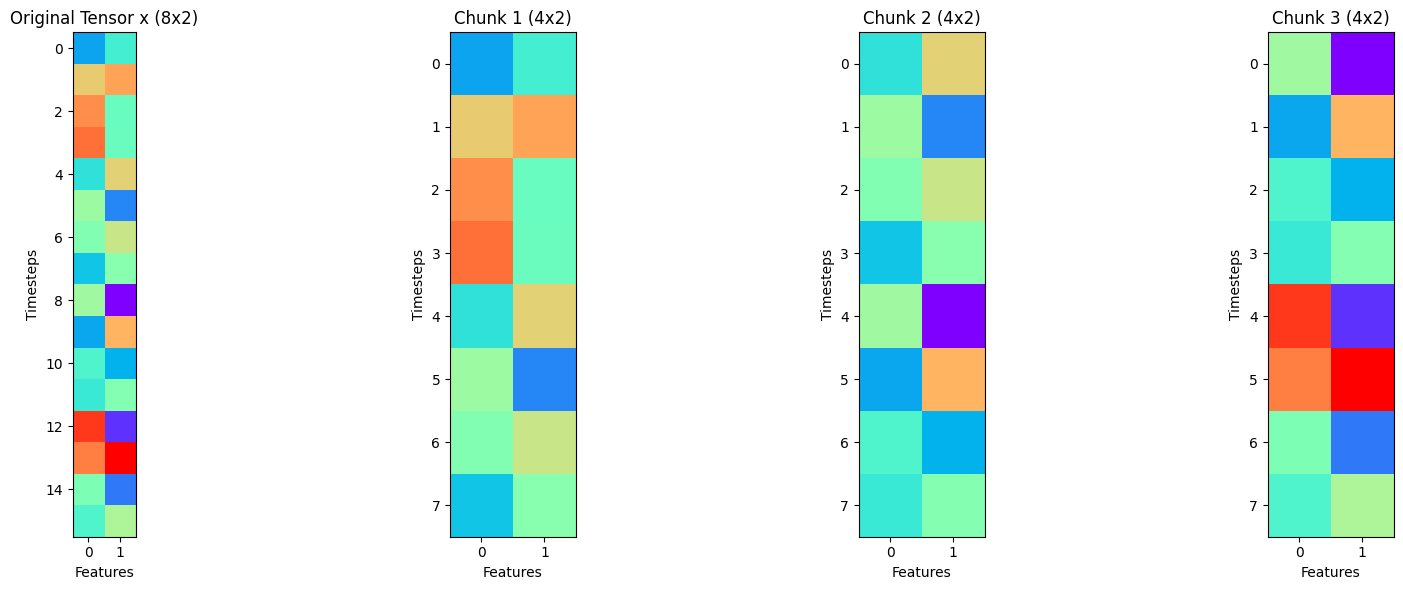

In [7]:
print("Input tensor x:")
print(x.shape)
print(x)

print(f"Chunked tensor x with overlap (size = {2*w}):")
print(chunked_x.shape)
print(chunked_x)

chunks_count = seqlen // w - 1
print(chunks_count)

# Plot original x and chunked x
fig, axs = plt.subplots(1, chunks_count+1, figsize=(18, 6))

# Set the color range for all plots
vmin, vmax = torch.min(x).item(), torch.max(x).item()

# Original tensor x (reshaped for better visualization)
im = axs[0].imshow(x[0].numpy(), cmap='rainbow', interpolation='nearest', vmin=vmin, vmax=vmax)
axs[0].set_title("Original Tensor x (8x2)")
axs[0].set_xlabel("Features")
axs[0].set_ylabel("Timesteps")

# Visualizing each chunk separately
for i, chunk in enumerate(chunked_x[0]):
    axs[i+1].imshow(chunk.numpy(), cmap='rainbow', interpolation='nearest', vmin=vmin, vmax=vmax)
    axs[i+1].set_title(f"Chunk {i+1} (4x2)")
    axs[i+1].set_xlabel("Features")
    axs[i+1].set_ylabel("Timesteps")

# Add a single colorbar for all subplots
# fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)

plt.tight_layout()
plt.show()

In [8]:
# Perform batched matrix multiplication to get chunk_attn
chunk_attn = torch.einsum('bcxd,bcyd->bcxy', chunked_x, chunked_x)

chunk_attn shape: torch.Size([1, 3, 8, 8])
[batch_size, num_chunks, chunk_size, chunk_size]

tensor([[[[ 1.6717, -1.7783, -1.6604, -1.8990,  0.3487,  0.3292, -0.4101,
            1.0608],
          [-1.7783,  2.5791,  1.1986,  1.4049,  0.5395, -1.5320,  0.9473,
           -0.7495],
          [-1.6604,  1.1986,  2.1183,  2.3944, -1.0983,  0.6492, -0.0148,
           -1.3666],
          [-1.8990,  1.4049,  2.3944,  2.7079, -1.2109,  0.6837,  0.0085,
           -1.5442],
          [ 0.3487,  0.5395, -1.0983, -1.2109,  1.2784, -1.4965,  0.5913,
            0.7231],
          [ 0.3292, -1.5320,  0.6492,  0.6837, -1.4965,  2.0967, -0.9593,
           -0.4426],
          [-0.4101,  0.9473, -0.0148,  0.0085,  0.5913, -0.9593,  0.4805,
            0.0215],
          [ 1.0608, -0.7495, -1.3666, -1.5442,  0.7231, -0.4426,  0.0215,
            0.8820]],

         [[ 1.2784, -1.4965,  0.5913,  0.7231, -2.2476,  1.8423, -0.7562,
            0.4600],
          [-1.4965,  2.0967, -0.9593, -0.4426,  3.

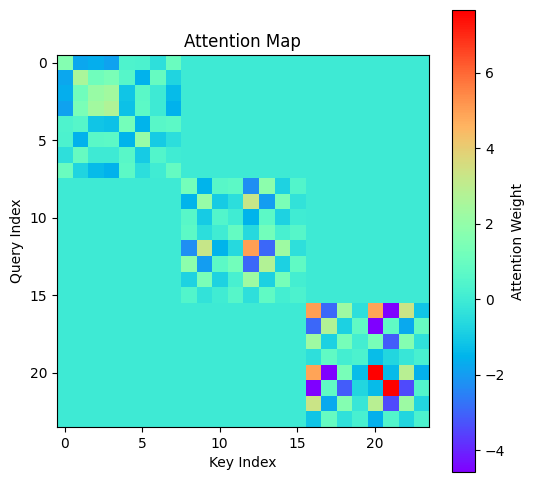

In [17]:

print("chunk_attn shape:", chunk_attn.shape)
print("[batch_size, num_chunks, chunk_size, chunk_size]")
print()
print(chunk_attn)

num_chunks, chunk_size = chunk_attn.size(1), chunk_attn.size(2)

# Smart construction of the 4x4 attention map directly from chunk_attn
attn_map = torch.block_diag(*chunk_attn[0])

# Plot the attention map
plt.figure(figsize=(6, 6))
plt.imshow(attn_map.numpy(), cmap='rainbow', interpolation='nearest')
plt.colorbar(label="Attention Weight")
plt.title("Attention Map")
plt.xlabel("Key Index")
plt.ylabel("Query Index")
plt.show()

In [11]:
def _skew(x, direction, padding_value):
    '''Convert diagonals into columns (or columns into diagonals depending on `direction`'''
    x_padded = F.pad(x, direction, value=padding_value)
    x_padded = x_padded.view(*x_padded.size()[:-2], x_padded.size(-1), x_padded.size(-2))
    return x_padded


In [12]:
diagonal_chunk_attn = _skew(chunk_attn, direction=(0, 0, 0, 1), padding_value=0)
print("Skewed tensor attn (converted diagonals into columns):")
print(diagonal_chunk_attn.shape)
print(diagonal_chunk_attn)

Skewed tensor attn (converted diagonals into columns):
torch.Size([1, 3, 8, 9])
tensor([[[[ 1.6717, -1.7783, -1.6604, -1.8990,  0.3487,  0.3292, -0.4101,
            1.0608, -1.7783],
          [ 2.5791,  1.1986,  1.4049,  0.5395, -1.5320,  0.9473, -0.7495,
           -1.6604,  1.1986],
          [ 2.1183,  2.3944, -1.0983,  0.6492, -0.0148, -1.3666, -1.8990,
            1.4049,  2.3944],
          [ 2.7079, -1.2109,  0.6837,  0.0085, -1.5442,  0.3487,  0.5395,
           -1.0983, -1.2109],
          [ 1.2784, -1.4965,  0.5913,  0.7231,  0.3292, -1.5320,  0.6492,
            0.6837, -1.4965],
          [ 2.0967, -0.9593, -0.4426, -0.4101,  0.9473, -0.0148,  0.0085,
            0.5913, -0.9593],
          [ 0.4805,  0.0215,  1.0608, -0.7495, -1.3666, -1.5442,  0.7231,
           -0.4426,  0.0215],
          [ 0.8820,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000]],

         [[ 1.2784, -1.4965,  0.5913,  0.7231, -2.2476,  1.8423, -0.7562,
            

In [14]:
# allocate space for the overall attention matrix where the chunks are compined. The last dimension
# has (w * 2 + 1) columns. The first (w) columns are the w lower triangles (attention from a word to
# w previous words). The following column is attention score from each word to itself, then
# followed by w columns for the upper triangle.
chunks_count = seqlen // w - 1
# print(chunks_count)

diagonal_attn = diagonal_chunk_attn.new_zeros((batch_size, chunks_count + 1, w, w * 2 + 1))
# print(diagonal_attn.shape)
# print(diagonal_attn)


# copy parts from diagonal_chunk_attn into the compined matrix of attentions
# - copying the main diagonal and the upper triangle
diagonal_attn[:, :-1, :, w:] = diagonal_chunk_attn[:, :, :w, :w + 1]
diagonal_attn[:, -1, :, w:] = diagonal_chunk_attn[:, -1, w:, :w + 1]
# - copying the lower triangle
diagonal_attn[:, 1:, :, :w] = diagonal_chunk_attn[:, :, - (w + 1):-1, w + 1:]
diagonal_attn[:, 0, 1:w, 1:w] = diagonal_chunk_attn[:, 0, :w - 1, 1 - w:]

diagonal_attn= tensor([[[[ 0.0000,  0.0000,  0.0000,  0.0000,  1.6717, -1.7783, -1.6604,
           -1.8990,  0.3487],
          [ 0.0000, -0.4101,  1.0608, -1.7783,  2.5791,  1.1986,  1.4049,
            0.5395, -1.5320],
          [ 0.0000, -0.7495, -1.6604,  1.1986,  2.1183,  2.3944, -1.0983,
            0.6492, -0.0148],
          [ 0.0000, -1.8990,  1.4049,  2.3944,  2.7079, -1.2109,  0.6837,
            0.0085, -1.5442]],

         [[ 0.3487,  0.5395, -1.0983, -1.2109,  1.2784, -1.4965,  0.5913,
            0.7231, -2.2476],
          [-1.5320,  0.6492,  0.6837, -1.4965,  2.0967, -0.9593, -0.4426,
            3.2348, -1.9854],
          [-0.0148,  0.0085,  0.5913, -0.9593,  0.4805,  0.0215, -1.5074,
            0.7194, -0.7816],
          [-1.5442,  0.7231, -0.4426,  0.0215,  0.8820, -0.5640,  1.2425,
            0.2251,  0.5401]],

         [[-2.2476,  3.2348, -1.5074, -0.5640,  5.0087, -2.9391,  2.3055,
           -0.3901,  4.9154],
          [-1.9854,  0.7194,  1.2425, -2.9391

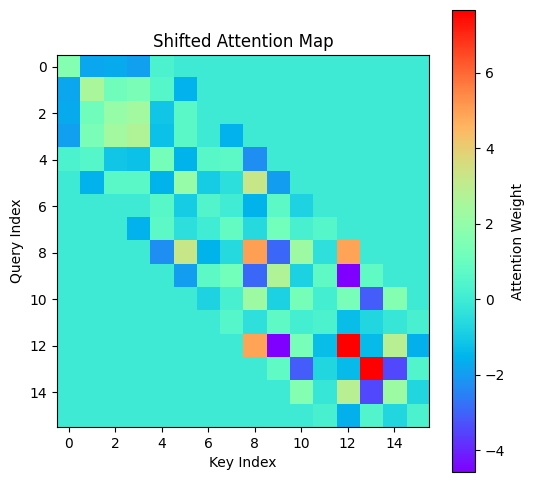

In [19]:
print("diagonal_attn=", diagonal_attn)

# Squeeze diagonal_attn to shape
squeezed_attn = diagonal_attn.squeeze().view(seqlen, 2*w+1)

# Create an 8x8 attention map with a right shift for each row
shifted_attn_map = torch.zeros(seqlen, seqlen+2*w)
for i, row in enumerate(squeezed_attn):
    shifted_attn_map[i, i:i + row.size(0)] = row

# Plot the attention map
plt.figure(figsize=(6, 6))
plt.imshow(shifted_attn_map.numpy()[:, w:seqlen+w], cmap='rainbow', interpolation='nearest')
plt.colorbar(label="Attention Weight")
plt.title("Shifted Attention Map")
plt.xlabel("Key Index")
plt.ylabel("Query Index")
plt.show()